In [1]:
import torch
 
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
 
if torch.cuda.is_available():
    print("GPU device name:", torch.cuda.get_device_name(0))
else:
    print("No GPU detected.")

PyTorch version: 2.5.1+cu124
CUDA available: True
GPU device name: Tesla P100-PCIE-16GB


In [2]:
%run train.py

Namespace(model_path='models/', crop_size=224, vocab_path='data/vocab.pkl', image_dir='data/resized2014', caption_path='data/annotations/captions_train2014.json', log_step=10, save_step=1000, embed_size=256, hidden_size=512, num_layers=1, num_epochs=3, batch_size=128, num_workers=2, learning_rate=0.001)
loading annotations into memory...
Done (t=0.85s)
creating index...
index created!


/home/nyerrago/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/nyerrago/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nyerrago/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1

Epoch [0/3], Step [0/3236], Loss: 9.2018, Perplexity: 9915.1998
Epoch [0/3], Step [10/3236], Loss: 5.7527, Perplexity: 315.0315
Epoch [0/3], Step [20/3236], Loss: 5.2764, Perplexity: 195.6556
Epoch [0/3], Step [30/3236], Loss: 4.9471, Perplexity: 140.7628
Epoch [0/3], Step [40/3236], Loss: 4.4246, Perplexity: 83.4822
Epoch [0/3], Step [50/3236], Loss: 4.2366, Perplexity: 69.1755
Epoch [0/3], Step [60/3236], Loss: 4.0953, Perplexity: 60.0591
Epoch [0/3], Step [70/3236], Loss: 4.0882, Perplexity: 59.6300
Epoch [0/3], Step [80/3236], Loss: 4.0104, Perplexity: 55.1677
Epoch [0/3], Step [90/3236], Loss: 4.1316, Perplexity: 62.2786
Epoch [0/3], Step [100/3236], Loss: 3.8674, Perplexity: 47.8171
Epoch [0/3], Step [110/3236], Loss: 3.7482, Perplexity: 42.4456
Epoch [0/3], Step [120/3236], Loss: 3.7497, Perplexity: 42.5065
Epoch [0/3], Step [130/3236], Loss: 3.6549, Perplexity: 38.6632
Epoch [0/3], Step [140/3236], Loss: 3.5573, Perplexity: 35.0685
Epoch [0/3], Step [150/3236], Loss: 3.5625, Pe

/home/nyerrago/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nyerrago/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/data/user/home/nyerrago/DL_Project/Project/image_captioning/sample.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorc

<start> a dog is sitting on a couch with a remote control . <end>


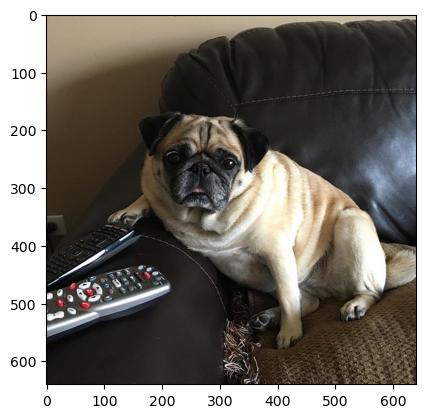

In [1]:
%run sample.py --image='png/dog2.jpg'

train.py

In [ ]:
import argparse
import torch
import torch.nn as nn
import numpy as np
import os
import pickle
from data_loader import get_loader 
from build_vocab import Vocabulary
from model import EncoderCNN, DecoderRNN
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import transforms


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def main(args):
    # Create model directory
    if not os.path.exists(args.model_path):
        os.makedirs(args.model_path)
    
    # Image preprocessing, normalization for the pretrained resnet
    transform = transforms.Compose([ 
        transforms.RandomCrop(args.crop_size),
        transforms.RandomHorizontalFlip(), 
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])
    
    # Load vocabulary wrapper
    with open(args.vocab_path, 'rb') as f:
        vocab = pickle.load(f)
    
    # Build data loader
    data_loader = get_loader(args.image_dir, args.caption_path, vocab, 
                             transform, args.batch_size,
                             shuffle=True, num_workers=args.num_workers) 

    # Build the models
    encoder = EncoderCNN(args.embed_size).to(device)
    decoder = DecoderRNN(args.embed_size, args.hidden_size, len(vocab), args.num_layers).to(device)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
    optimizer = torch.optim.Adam(params, lr=args.learning_rate)
    
    # Train the models
    total_step = len(data_loader)
    for epoch in range(args.num_epochs):
        for i, (images, captions, lengths) in enumerate(data_loader):
            
            # Set mini-batch dataset
            images = images.to(device)
            captions = captions.to(device)
            targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
            
            # Forward, backward and optimize
            features = encoder(images)
            outputs = decoder(features, captions, lengths)
            loss = criterion(outputs, targets)
            decoder.zero_grad()
            encoder.zero_grad()
            loss.backward()
            optimizer.step()

            # Print log info
            if i % args.log_step == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                      .format(epoch, args.num_epochs, i, total_step, loss.item(), np.exp(loss.item()))) 
                
            # Save the model checkpoints
            if (i+1) % args.save_step == 0:
                torch.save(decoder.state_dict(), os.path.join(
                    args.model_path, 'decoder-{}-{}.ckpt'.format(epoch+1, i+1)))
                torch.save(encoder.state_dict(), os.path.join(
                    args.model_path, 'encoder-{}-{}.ckpt'.format(epoch+1, i+1)))


if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--model_path', type=str, default='models/' , help='path for saving trained models')
    parser.add_argument('--crop_size', type=int, default=224 , help='size for randomly cropping images')
    parser.add_argument('--vocab_path', type=str, default='data/vocab.pkl', help='path for vocabulary wrapper')
    parser.add_argument('--image_dir', type=str, default='data/resized2014', help='directory for resized images')
    parser.add_argument('--caption_path', type=str, default='data/annotations/captions_train2014.json', help='path for train annotation json file')
    parser.add_argument('--log_step', type=int , default=10, help='step size for prining log info')
    parser.add_argument('--save_step', type=int , default=1000, help='step size for saving trained models')
    
    # Model parameters
    parser.add_argument('--embed_size', type=int , default=256, help='dimension of word embedding vectors')
    parser.add_argument('--hidden_size', type=int , default=512, help='dimension of lstm hidden states')
    parser.add_argument('--num_layers', type=int , default=1, help='number of layers in lstm')
    
    parser.add_argument('--num_epochs', type=int, default=3)
    parser.add_argument('--batch_size', type=int, default=128)
    parser.add_argument('--num_workers', type=int, default=2)
    parser.add_argument('--learning_rate', type=float, default=0.001)
    args = parser.parse_args()
    print(args)
    main(args)

sample.py

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np 
import argparse
import pickle 
import os
from torchvision import transforms 
from build_vocab import Vocabulary
from model import EncoderCNN, DecoderRNN
from PIL import Image


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_image(image_path, transform=None):
    image = Image.open(image_path).convert('RGB')
    image = image.resize([224, 224], Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image

def main(args):
    # Image preprocessing
    transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])
    
    # Load vocabulary wrapper
    with open(args.vocab_path, 'rb') as f:
        vocab = pickle.load(f)

    # Build models
    encoder = EncoderCNN(args.embed_size).eval()  # eval mode (batchnorm uses moving mean/variance)
    decoder = DecoderRNN(args.embed_size, args.hidden_size, len(vocab), args.num_layers)
    encoder = encoder.to(device)
    decoder = decoder.to(device)

    # Load the trained model parameters
    encoder.load_state_dict(torch.load(args.encoder_path))
    decoder.load_state_dict(torch.load(args.decoder_path))

    # Prepare an image
    image = load_image(args.image, transform)
    image_tensor = image.to(device)
    
    # Generate an caption from the image
    feature = encoder(image_tensor)
    sampled_ids = decoder.sample(feature)
    sampled_ids = sampled_ids[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)
    
    # Convert word_ids to words
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(sampled_caption)
    
    # Print out the image and the generated caption
    print (sentence)
    image = Image.open(args.image)
    plt.imshow(np.asarray(image))
    
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--image', type=str, required=True, help='input image for generating caption')
    parser.add_argument('--encoder_path', type=str, default='model2/encoder-5-3000.pkl', help='path for trained encoder')
    parser.add_argument('--decoder_path', type=str, default='model2/decoder-5-3000.pkl', help='path for trained decoder')
    parser.add_argument('--vocab_path', type=str, default='model2/vocab.pkl', help='path for vocabulary wrapper')
    
    # Model parameters (should be same as paramters in train.py)
    parser.add_argument('--embed_size', type=int , default=256, help='dimension of word embedding vectors')
    parser.add_argument('--hidden_size', type=int , default=512, help='dimension of lstm hidden states')
    parser.add_argument('--num_layers', type=int , default=1, help='number of layers in lstm')
    args = parser.parse_args()
    main(args)


resize.py

In [ ]:
import argparse
import os
from PIL import Image


def resize_image(image, size):
    """Resize an image to the given size."""
    return image.resize(size, Image.ANTIALIAS)

def resize_images(image_dir, output_dir, size):
    """Resize the images in 'image_dir' and save into 'output_dir'."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    images = os.listdir(image_dir)
    num_images = len(images)
    for i, image in enumerate(images):
        with open(os.path.join(image_dir, image), 'r+b') as f:
            with Image.open(f) as img:
                img = resize_image(img, size)
                img.save(os.path.join(output_dir, image), img.format)
        if (i+1) % 100 == 0:
            print ("[{}/{}] Resized the images and saved into '{}'."
                   .format(i+1, num_images, output_dir))

def main(args):
    image_dir = args.image_dir
    output_dir = args.output_dir
    image_size = [args.image_size, args.image_size]
    resize_images(image_dir, output_dir, image_size)


if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--image_dir', type=str, default='./data/train2014/',
                        help='directory for train images')
    parser.add_argument('--output_dir', type=str, default='./data/resized2014/',
                        help='directory for saving resized images')
    parser.add_argument('--image_size', type=int, default=256,
                        help='size for image after processing')
    args = parser.parse_args()
    main(args)

build_vocab.py

In [ ]:
import nltk
import pickle
import argparse
from collections import Counter
from pycocotools.coco import COCO


class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

def build_vocab(json, threshold):
    """Build a simple vocabulary wrapper."""
    coco = COCO(json)
    counter = Counter()
    ids = coco.anns.keys()
    for i, id in enumerate(ids):
        caption = str(coco.anns[id]['caption'])
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        counter.update(tokens)

        if (i+1) % 1000 == 0:
            print("[{}/{}] Tokenized the captions.".format(i+1, len(ids)))

    # If the word frequency is less than 'threshold', then the word is discarded.
    words = [word for word, cnt in counter.items() if cnt >= threshold]

    # Create a vocab wrapper and add some special tokens.
    vocab = Vocabulary()
    vocab.add_word('<pad>')
    vocab.add_word('<start>')
    vocab.add_word('<end>')
    vocab.add_word('<unk>')

    # Add the words to the vocabulary.
    for i, word in enumerate(words):
        vocab.add_word(word)
    return vocab

def main(args):
    vocab = build_vocab(json=args.caption_path, threshold=args.threshold)
    vocab_path = args.vocab_path
    with open(vocab_path, 'wb') as f:
        pickle.dump(vocab, f)
    print("Total vocabulary size: {}".format(len(vocab)))
    print("Saved the vocabulary wrapper to '{}'".format(vocab_path))


if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--caption_path', type=str, 
                        default='data/annotations/captions_train2014.json', 
                        help='path for train annotation file')
    parser.add_argument('--vocab_path', type=str, default='./data/vocab.pkl', 
                        help='path for saving vocabulary wrapper')
    parser.add_argument('--threshold', type=int, default=4, 
                        help='minimum word count threshold')
    args = parser.parse_args()
    main(args)

dataloader.py

In [ ]:
import torch
import torchvision.transforms as transforms
import torch.utils.data as data
import os
import pickle
import numpy as np
import nltk
from PIL import Image
from build_vocab import Vocabulary
from pycocotools.coco import COCO


class CocoDataset(data.Dataset):
    """COCO Custom Dataset compatible with torch.utils.data.DataLoader."""
    def __init__(self, root, json, vocab, transform=None):
        """Set the path for images, captions and vocabulary wrapper.
        
        Args:
            root: image directory.
            json: coco annotation file path.
            vocab: vocabulary wrapper.
            transform: image transformer.
        """
        self.root = root
        self.coco = COCO(json)
        self.ids = list(self.coco.anns.keys())
        self.vocab = vocab
        self.transform = transform

    def __getitem__(self, index):
        """Returns one data pair (image and caption)."""
        coco = self.coco
        vocab = self.vocab
        ann_id = self.ids[index]
        caption = coco.anns[ann_id]['caption']
        img_id = coco.anns[ann_id]['image_id']
        path = coco.loadImgs(img_id)[0]['file_name']

        image = Image.open(os.path.join(self.root, path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        # Convert caption (string) to word ids.
        tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(vocab('<start>'))
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab('<end>'))
        target = torch.Tensor(caption)
        return image, target

    def __len__(self):
        return len(self.ids)


def collate_fn(data):
    """Creates mini-batch tensors from the list of tuples (image, caption).
    
    We should build custom collate_fn rather than using default collate_fn, 
    because merging caption (including padding) is not supported in default.

    Args:
        data: list of tuple (image, caption). 
            - image: torch tensor of shape (3, 256, 256).
            - caption: torch tensor of shape (?); variable length.

    Returns:
        images: torch tensor of shape (batch_size, 3, 256, 256).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length (descending order).
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Merge captions (from tuple of 1D tensor to 2D tensor).
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]        
    return images, targets, lengths

def get_loader(root, json, vocab, transform, batch_size, shuffle, num_workers):
    """Returns torch.utils.data.DataLoader for custom coco dataset."""
    # COCO caption dataset
    coco = CocoDataset(root=root,
                       json=json,
                       vocab=vocab,
                       transform=transform)
    
    # Data loader for COCO dataset
    # This will return (images, captions, lengths) for each iteration.
    # images: a tensor of shape (batch_size, 3, 224, 224).
    # captions: a tensor of shape (batch_size, padded_length).
    # lengths: a list indicating valid length for each caption. length is (batch_size).
    data_loader = torch.utils.data.DataLoader(dataset=coco, 
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              num_workers=num_workers,
                                              collate_fn=collate_fn)
    return data_loader

model.py

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence


class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids